<a href="https://colab.research.google.com/github/degar405/ExperimentacoesPreDiagnosticoGlaucoma/blob/main/Trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


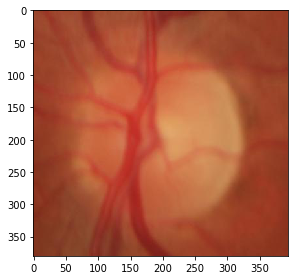

(array([[12,  8,  9, ...,  4,  7, 12],
       [ 8, 15, 12, ...,  6,  9,  9],
       [ 6, 14, 14, ...,  2,  4,  5],
       ...,
       [ 7,  4,  1, ..., 15, 16, 11],
       [ 9,  6,  4, ..., 10, 12, 11],
       [11,  8,  6, ..., 10, 12, 11]]), array([[14056,  3062,   138, ...,    14,   127,  2644],
       [ 3013,  3830,   480, ...,     2,    16,   280],
       [  155,   446,   336, ...,     0,     3,    18],
       ...,
       [    5,     0,     0, ...,    59,    86,    54],
       [  168,    10,     0, ...,    63,   306,   436],
       [ 2658,   268,     9, ...,    64,   440,  3388]]), array([[10791,  2635,   192, ...,    38,   208,  2953],
       [ 2625,  3394,   476, ...,    13,    46,   476],
       [  186,   486,   373, ...,     2,    10,    51],
       ...,
       [   38,    10,     2, ...,   146,   133,   116],
       [  222,    44,    12, ...,   127,   346,   522],
       [ 2984,   468,    48, ...,   108,   526,  3925]]), array([[23264,  2816,     0, ...,     0,     0,  2738],
 

In [18]:
from google.colab import drive
from os import listdir
from skimage import io
import pywt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Colab Notebooks/Trabalho/'

def exibirImagensCoeficientesWavelet(coeffs):
  titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
  LL, (LH, HL, HH) = coeffs

  fig = plt.figure(figsize=(12, 3))
  for i, a in enumerate([LL, LH, HL, HH]):
      ax = fig.add_subplot(1, 4, i + 1)
      ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
      ax.set_title(titles[i], fontsize=10)
      ax.set_xticks([])
      ax.set_yticks([])

  fig.tight_layout()
  plt.show()

def separarCanaisRGB(imagem):
  canalR = []
  canalG = []
  canalB = []

  for linha in imagem:
    linhaR = []
    linhaG = []
    linhaB = []

    for pixel in linha:
      linhaR.append(pixel[0])
      linhaG.append(pixel[1])
      linhaB.append(pixel[2])

    canalR.append(linhaR)
    canalG.append(linhaG)
    canalB.append(linhaB)
  
  return (np.array(canalR), np.array(canalG), np.array(canalB))

def aplicarWavelet(imagem, implementacao):
  return pywt.dwt2(imagem, implementacao)

def combinarImagensEmTonsDeCinza(R, G, B):
  imagem = []
  quantidadeLinhas = len(R)
  quantidadeColunas = len(R[0])

  for nLinha in range(0, quantidadeLinhas):
    linha = []

    for nColuna in range(0, quantidadeColunas):
      pixel = round(0.2126 * R[nLinha][nColuna] + 0.7154 * G[nLinha][nColuna] + 0.0721 * B[nLinha][nColuna])
      linha.append(pixel)

    imagem.append(linha)

  return imagem

def combinarCoeficientesWavelet(coeficientesR, coeficientesG, coeficientesB):
  (LLR, (LHR, HLR, HHR)) = coeficientesR
  (LLG, (LHG, HLG, HHG)) = coeficientesG
  (LLB, (LHB, HLB, HHB)) = coeficientesB

  LL = combinarImagensEmTonsDeCinza(LLR, LLG, LLB)
  LH = combinarImagensEmTonsDeCinza(LHR, LHG, LHB)
  HL = combinarImagensEmTonsDeCinza(HLR, HLG, HLB)
  HH = combinarImagensEmTonsDeCinza(HHR, HHG, HHB)

  return (LL, (LH, HL, HH))

def aplicarGlcm(imagem):
  distancias = [1]
  direcoes = [0, np.pi/4, np.pi/2, 3*np.pi/4]
  resultadoGlcm = graycomatrix(np.array(imagem, dtype=np.uint8), distancias, direcoes)

  qtdDirecoes = len(direcoes)
  matrizes = []
  for i in range(0, qtdDirecoes):
    matrizes.append(resultadoGlcm[:, :, 0, i])

  niveis = len(matrizes[0])
  matrizRetorno = []
  for nLinha in range(0, niveis):
    linha = []
    for nColuna in range(0, niveis):
      acumuladorFrequencia = 0
      for matriz in matrizes:
        acumuladorFrequencia += matriz[nLinha, nColuna]
      linha.append(round(acumuladorFrequencia/qtdDirecoes))
    matrizRetorno.append(linha)

  matrizRetorno = np.array(matrizRetorno)
  return matrizRetorno

def aplicarDescritoresDeTextura(imagem, implementacaoWavelet):
  (canalR, canalG, canalB) = separarCanaisRGB(imagem)

  coeficientesWaveletR = aplicarWavelet(canalR, implementacaoWavelet)
  coeficientesWaveletG = aplicarWavelet(canalG, implementacaoWavelet)
  coeficientesWaveletB = aplicarWavelet(canalB, implementacaoWavelet)

  coeficientesWavelet = combinarCoeficientesWavelet(coeficientesWaveletR, coeficientesWaveletG, coeficientesWaveletB)

  #exibirImagensCoeficientesWavelet(coeficientesWavelet)
  LL, (LH , HL, HH) = coeficientesWavelet
  return (aplicarGlcm(LL), aplicarGlcm(LH), aplicarGlcm(HL), aplicarGlcm(HH))

imagemTeste = io.imread(root_path + "Normal/Im001.jpg")
io.imshow(imagemTeste)
io.show()

mapasDeTextura = aplicarDescritoresDeTextura(imagemTeste, "haar")
print(mapasDeTextura)